## The Model: Period Prediction

#### Data Preparation

In [104]:
import pandas as pd

df = pd.read_csv("period_data.csv") #load data
df = pd.DataFrame(df) #convert to dataframe



In [105]:
df.isnull().sum()

LoggedDate      0
CycleLength     0
OvulationDay    0
PeriodDate      0
dtype: int64

In [106]:
df.shape

(1000, 4)

In [107]:
df["LoggedDate"] = pd.to_datetime(df['LoggedDate'])
df['PeriodDate'] = pd.to_datetime(df['PeriodDate'])

df = df[pd.to_numeric(df['LoggedDate'], errors='coerce').notna()]
df = df[pd.to_numeric(df['PeriodDate'], errors='coerce').notna()]

In [108]:
#chck missing values
df.isna().any

<bound method NDFrame._add_numeric_operations.<locals>.any of      LoggedDate  CycleLength  OvulationDay  PeriodDate
0         False        False         False       False
1         False        False         False       False
2         False        False         False       False
3         False        False         False       False
4         False        False         False       False
..          ...          ...           ...         ...
995       False        False         False       False
996       False        False         False       False
997       False        False         False       False
998       False        False         False       False
999       False        False         False       False

[1000 rows x 4 columns]>

### Exploration

<function matplotlib.pyplot.show(close=None, block=None)>

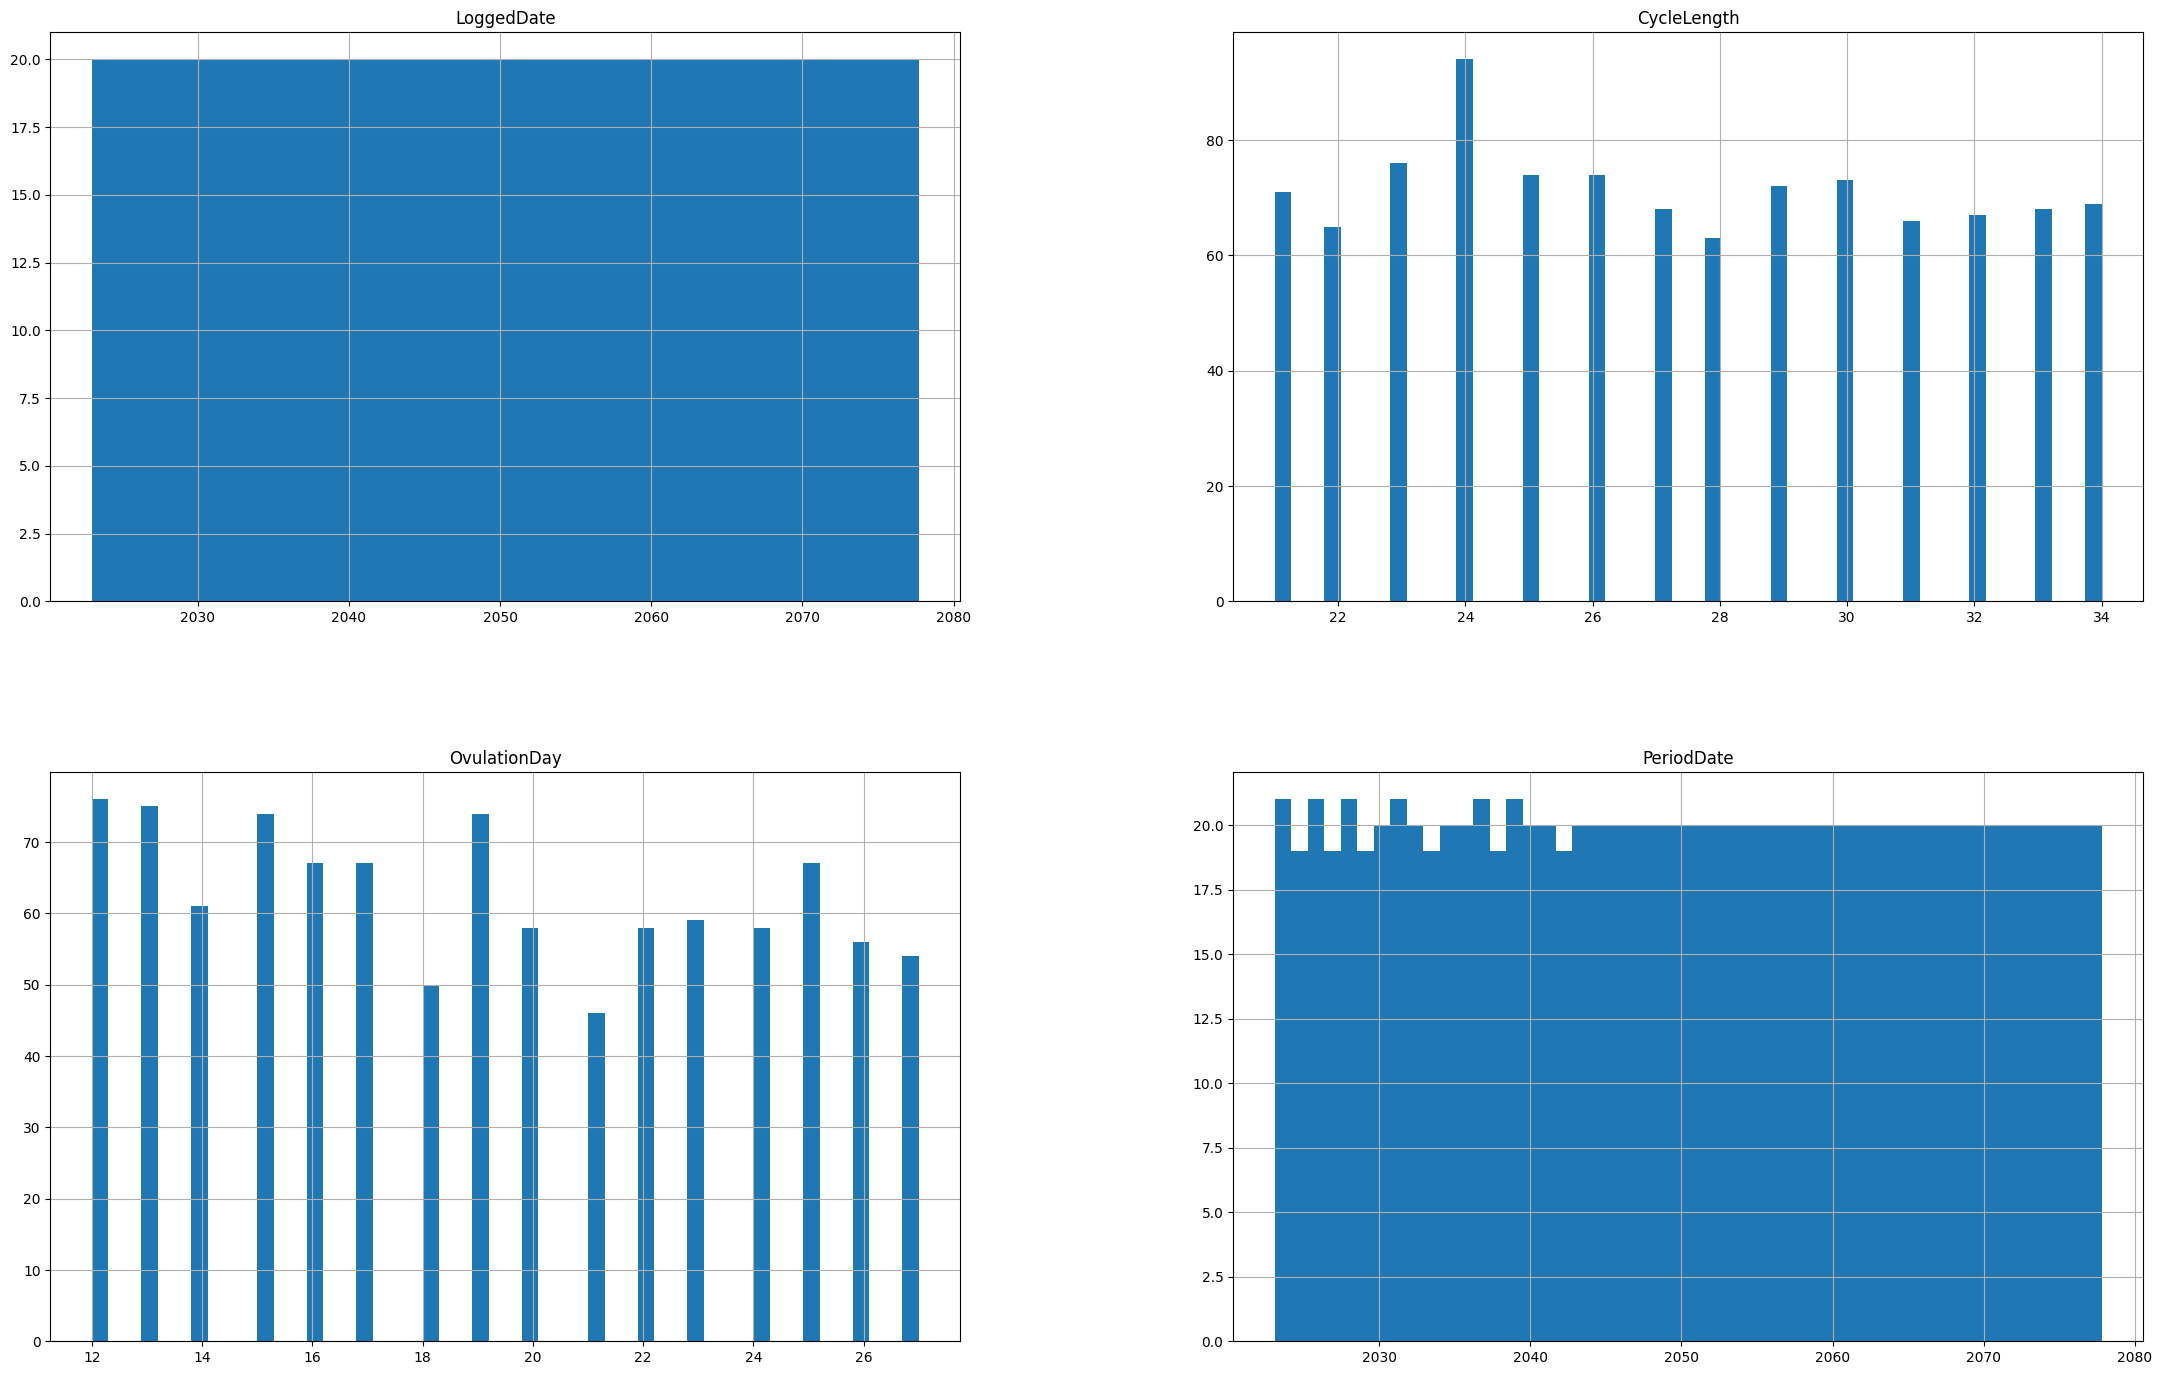

In [109]:
#plot each attribute to check range for scaling
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(27,17))
plt.show

In [110]:
#feature selection
X = df[['LoggedDate']]
y = df['PeriodDate']


### Data Splitting

In [111]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Model

In [112]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
model = rf.fit(X_train, y_train)

In [113]:
# make predictions
y_pred = rf.predict(X_test)

### Model Evaluation

In [114]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_test = y_test.values.astype(float)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [115]:
#model validation
from sklearn.model_selection import cross_val_score

# cross validation scores (10 fold cross validation)
cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error') 


/home/sunday/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py", line 478, in mean_squared_error
    output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
numpy.core._exceptions._UFuncBinaryResolutionError: ufunc 'subtract' cannot use o

In [116]:
cv_scores = -(cv_scores)  #convert -ve to positive mses
rmse_scores = np.sqrt(cv_scores) # calculating root mean square for each fold
avg_rmse = rmse_scores.mean() # average rmse
#display average rmse
avg_rmse

nan

### Fine Tuning

In [117]:


from sklearn.model_selection import GridSearchCV


parameters = [
    {'n_estimators': [10,20,30], 'max_features': [None, 'auto', 'sqrt', 'log2', 1, 2, 3]},
    {'bootstrap': [True, False], 'n_estimators': [10,20,30], 'max_features': [None, 'auto', 'sqrt', 'log2', 1, 2, 3]}
]




#grid search
grid_search = GridSearchCV(rf, parameters, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


/home/sunday/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/m

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [None, 'auto', 'sqrt', 'log2', 1, 2,
                                           3],
                          'n_estimators': [10, 20, 30]},
                         {'bootstrap': [True, False],
                          'max_features': [None, 'auto', 'sqrt', 'log2', 1, 2,
                                           3],
                          'n_estimators': [10, 20, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [118]:
# grid_search = GridSearchCV(rf, parameters, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
# grid_search.fit(X_train, y_train)
best_parameters=grid_search.best_params_


### Model Evaluation

In [119]:
# using test set
model2 = grid_search.best_estimator_
prediction2 = model2.predict(X_test)

In [120]:
#root mean squared error on test set
mse_2 = mean_squared_error(y_test, prediction2)
rmse_2 = np.sqrt(mse_2)


##### Performance

In [121]:
# validate model performance using 95% confidence
confidence_interval = 0.95
err_sqr = (prediction2 - y_test)**2

from scipy import stats

rmse_interval = np.sqrt(stats.t.interval(confidence_interval, len(err_sqr)-1, loc=err_sqr.mean(), scale=stats.sem(err_sqr)))


### Saving The Model

In [122]:
import pickle as pk
#save model
mlmodel = model2
filename = 'mlmodel.pickle'
with open(filename, 'wb') as f:
    pk.dump(mlmodel, f)